In [1]:
import csv

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [100]:
dataset = 'hand_landmarks_end.csv'
dataset_testGood = 'hand_landmarks_goodTest.csv'
dataset_testBad = 'hand_landmarks_badTest.csv'
dataset_testDark = 'hand_landmarks_darkTest.csv'
model_save_path = 'new_hand_classifier.hdf5'
tflite_save_path = 'new_hand_classifier.tflite'

# Set number of classes

In [101]:
NUM_CLASSES = 26

# Dataset reading

In [102]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [103]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
y_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='int32', usecols=(0))
y_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='int32', usecols=(0))
y_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='int32', usecols=(0))

In [104]:
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

# Model building

In [105]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21 * 2, )),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [106]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 21, 2, 1)          0         
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 2, 32)         128       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 10, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 2, 64)         6208      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 5, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 640)              

In [107]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [108]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [109]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
53/53 [==============================] - ETA: 0s - loss: 2.7039 - accuracy: 0.1935
Epoch 1: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 2s 11ms/step - loss: 2.7039 - accuracy: 0.1935 - val_loss: 1.8125 - val_accuracy: 0.4639
Epoch 2/1000
27/53 [==============>...............] - ETA: 0s - loss: 1.7489 - accuracy: 0.4164

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/53 [===========================>..] - ETA: 0s - loss: 1.5047 - accuracy: 0.4890
Epoch 2: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 0s 8ms/step - loss: 1.4913 - accuracy: 0.4930 - val_loss: 0.7533 - val_accuracy: 0.8340
Epoch 3/1000
47/53 [=========================>....] - ETA: 0s - loss: 0.7879 - accuracy: 0.7201
Epoch 3: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 0s 8ms/step - loss: 0.7670 - accuracy: 0.7284 - val_loss: 0.3726 - val_accuracy: 0.8997
Epoch 4/1000
46/53 [=========================>....] - ETA: 0s - loss: 0.5087 - accuracy: 0.8222
Epoch 4: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 0s 8ms/step - loss: 0.4969 - accuracy: 0.8277 - val_loss: 0.2213 - val_accuracy: 0.9431
Epoch 5/1000
45/53 [========================>.....] - ETA: 0s - loss: 0.3771 - accuracy: 0.8696
Epoch 5: saving model to new_hand_classifier.hdf5
53/53 [==============================] - 1

In [110]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testGood, y_testGood, batch_size=128)

19/19 [==============================] - 0s 2ms/step - loss: 0.1720 - accuracy: 0.9521


In [111]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testBad, y_testBad, batch_size=128)

19/19 [==============================] - 0s 2ms/step - loss: 1.8796 - accuracy: 0.7496


In [112]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testDark, y_testDark, batch_size=128)

19/19 [==============================] - 0s 3ms/step - loss: 1.0598 - accuracy: 0.9079


In [113]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [114]:
# Inference test
predict_result = model.predict(np.array([X_testGood[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 88ms/step
[1.0000000e+00 9.3952385e-32 1.0789320e-34 2.0678965e-23 0.0000000e+00
 1.2211517e-31 8.7531633e-14 1.0381574e-18 6.3734765e-25 1.6552401e-27
 2.0736424e-20 1.0620477e-17 2.2781642e-19 4.3179715e-19 2.1009171e-16
 6.1229627e-15 2.6372640e-15 0.0000000e+00 7.8668317e-17 1.1516306e-10
 1.3608983e-35 3.0887269e-36 7.5431843e-32 1.5196819e-11 1.7373943e-09
 7.5503640e-29]
0


# Confusion matrix

75/75 [==============================] - 0s 2ms/step


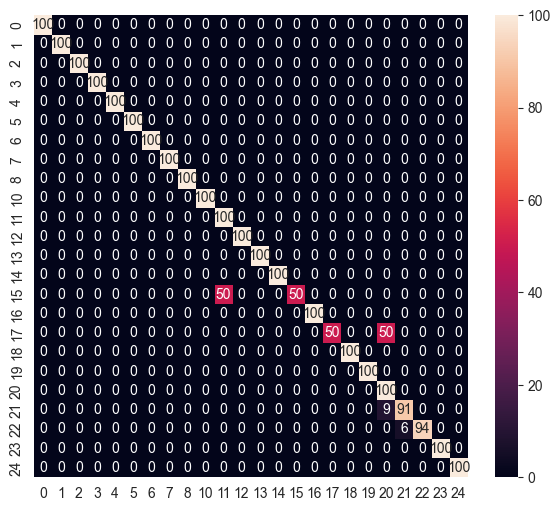

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       100
          10       1.00      1.00      1.00       100
          11       0.67      1.00      0.80       100
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00       100
          14       1.00      1.00      1.00       100
          15       1.00      0.50      0.67       100
          16       1.00      1.00      1.00       100
          17       1.00      0.50      0.67       100
     

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_testGood, y_pred))

Y_pred = model.predict(X_testGood)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_testGood, y_pred)

# Convert to model for Tensorflow-Lite

In [116]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [117]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpes1atvlm\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpes1atvlm\assets


105640

# Inference test

In [92]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [93]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [94]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [95]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [96]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.6500046e-24 3.1150623e-06 9.9999690e-01 5.3210531e-12 2.0201403e-09
 9.9114869e-11 1.2584551e-13 2.2020724e-15 1.9197074e-15 9.6436698e-21
 2.3694938e-28 2.0593869e-24 5.5851623e-13 6.4184349e-21 1.1397345e-11
 8.8580959e-16 5.8406832e-22 7.8624535e-18 1.0165540e-24 1.9994632e-24
 8.0019986e-27 5.1617608e-23 5.6928398e-22 2.6290272e-16 1.2467544e-15
 7.6688936e-20]
2


In [97]:
# Save the model
model.save(model_save_path, include_optimizer=False)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Write the TFLite file
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpn2yakdhh\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpn2yakdhh\assets


#### Loss  (cost)

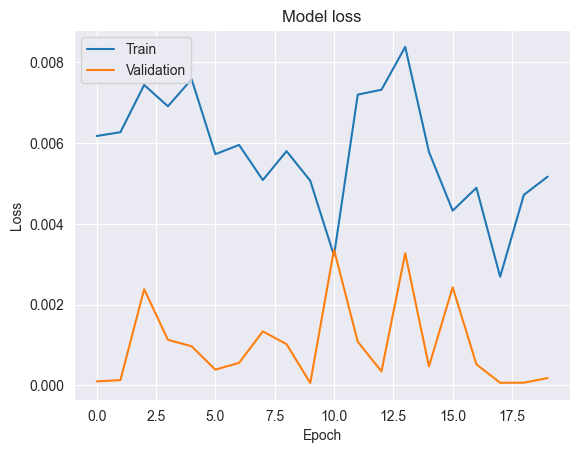

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

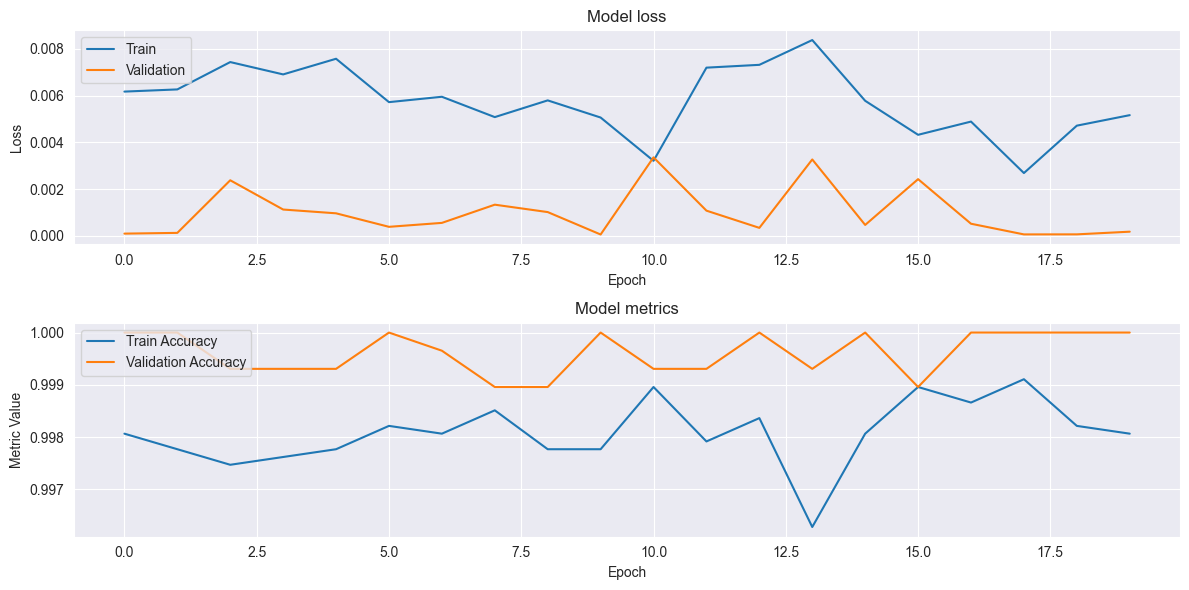

In [99]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

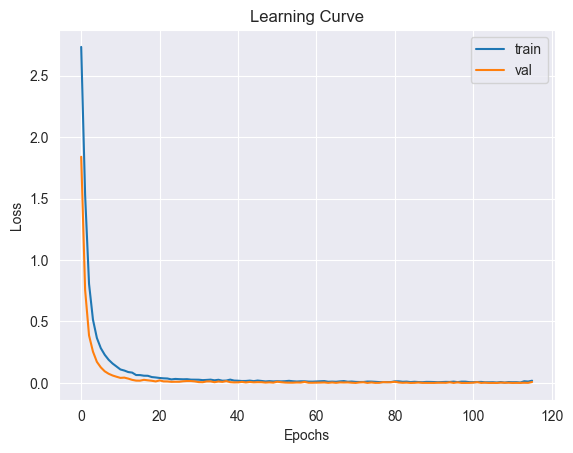

In [80]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()